In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score 


In [2]:
# pgAdmnin interface

In [3]:
# Pull in Data
df = pd.read_csv('Data/salmon_preprocessed_ws.csv')
df.head()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
0,1978,Chinook Salmon (Snake River Fall-run ESU) - Sn...,640.0,1.0,640.0,600.0,470.0,1000.0
1,1979,Chinook Salmon (Snake River Fall-run ESU) - Sn...,500.0,1.0,500.0,640.0,600.0,470.0
2,1980,Chinook Salmon (Snake River Fall-run ESU) - Sn...,450.0,1.0,450.0,500.0,640.0,600.0
3,1981,Chinook Salmon (Snake River Fall-run ESU) - Sn...,340.0,1.0,340.0,450.0,500.0,640.0
4,1982,Chinook Salmon (Snake River Fall-run ESU) - Sn...,720.0,1.0,720.0,340.0,450.0,500.0


In [4]:
# Isolate the Stream we want to teach the model on and reset index
target_df = df.loc[df['Nwr_Population_Name'] == 'Chinook Salmon (Snake River Spring/Summer-run ESU) - Imnaha River Mainstem']
target_df.reset_index(drop=True, inplace=True)
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Brood_Year                     63 non-null     int64  
 1   Nwr_Population_Name            63 non-null     object 
 2   Number_Of_Spawners             63 non-null     float64
 3   Fracwild                       63 non-null     float64
 4   Wild_Spawners                  63 non-null     float64
 5   Wild_Spawners_Prev_Yr          63 non-null     float64
 6   Wild_Spawners_Two_Yrs_Prior    63 non-null     float64
 7   Wild_Spawners_Three_Yrs_Prior  63 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 4.1+ KB


In [5]:
# Delete first three rows and reset index
target_df = target_df.drop(target_df.index[[0,1,3]])
target_df.reset_index(drop=True, inplace=True)
target_df.head()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
0,1951,Chinook Salmon (Snake River Spring/Summer-run ...,1761.0,1.0,1761.0,1024.0,1938.0,18.15
1,1953,Chinook Salmon (Snake River Spring/Summer-run ...,2920.0,1.0,2920.0,3574.0,1761.0,1024.00
2,1954,Chinook Salmon (Snake River Spring/Summer-run ...,3054.0,1.0,3054.0,2920.0,3574.0,1761.00
3,1955,Chinook Salmon (Snake River Spring/Summer-run ...,5856.0,1.0,5856.0,3054.0,2920.0,3574.00
4,1956,Chinook Salmon (Snake River Spring/Summer-run ...,1728.0,1.0,1728.0,5856.0,3054.0,2920.00


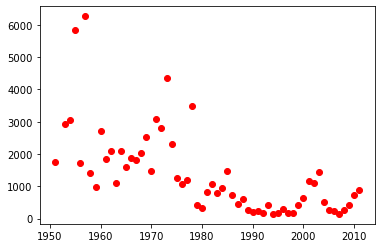

In [6]:
# Plot Brood Year vs Wild Spawners
plt.plot(target_df['Brood_Year'], target_df['Wild_Spawners'], 'ro')
#plt.axis([1948, 2020, 0, 1000])
plt.show()

In [7]:
# Create our Feature for target_df
# X = scaled_target_df[['Wild_Spawners_Prev_Yr_Sc', 'Wild_Spawners_Two_Yrs_Prior_Sc', 'Wild_Spawners_Three_Yrs_Prior_Sc']]
X = target_df[['Brood_Year', 'Wild_Spawners_Prev_Yr', 'Wild_Spawners_Two_Yrs_Prior', 'Wild_Spawners_Three_Yrs_Prior']]
# Create our Target
y = target_df['Wild_Spawners']

In [8]:
# #Scale idependent variables
# scaler = StandardScaler()
# scaled_target = target_df [[
#     'Wild_Spawners_Prev_Yr',
#     'Wild_Spawners_Two_Yrs_Prior',
#     'Wild_Spawners_Three_Yrs_Prior']].values.tolist()

# scaled_data =  scaler.fit_transform(scaled_target)

In [9]:
# #Create DatsFrame with scaled data
# scaled_df = pd.DataFrame(
#     data=scaled_data,
#     columns=['Wild_Spawners_Prev_Yr_Sc', 
#         'Wild_Spawners_Two_Yrs_Prior_Sc', 
#         'Wild_Spawners_Three_Yrs_Prior_Sc',],
#         index=target_df.index)

In [10]:
# # Delete columns of unscaled independent variables
# target_df.drop(columns = [
#     'Wild_Spawners_Prev_Yr',
#     'Wild_Spawners_Two_Yrs_Prior',
#     'Wild_Spawners_Three_Yrs_Prior'],
#     inplace=True)

# # Combine target_df and scaled_df
# scaled_target_df = pd.merge(target_df, scaled_df, left_index=True, right_index=True)
# scaled_target_df.head()

In [11]:
# # Create our Feature for Scaled_Target
# # X = scaled_target_df[['Wild_Spawners_Prev_Yr_Sc', 'Wild_Spawners_Two_Yrs_Prior_Sc', 'Wild_Spawners_Three_Yrs_Prior_Sc']]
# X = scaled_target_df[['Brood_Year', 'Wild_Spawners_Prev_Yr_Sc', 'Wild_Spawners_Two_Yrs_Prior_Sc', 'Wild_Spawners_Three_Yrs_Prior_Sc']]
# # Create our Target
# y = scaled_target_df['Wild_Spawners']


In [12]:
# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28, test_size =0.2)
#Counter(y_train)

In [13]:
# Set up a regression ML model
# Create linear regression object
l_regr = linear_model.LinearRegression()

# Train the model using the training sets
l_regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = l_regr.predict(X_test)

In [14]:
print("Coefficients: \n", l_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Square root of the mean squared
print('Root Mean Squared error of is:',np.sqrt(mean_squared_error(y_test,y_pred)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# Accuracy Score
l_regr.score(X_test, y_test)

Coefficients: 
 [-33.62812815   0.04441284   0.22749237   0.07399708]
Mean squared error: 453198.07
Root Mean Squared error of is: 673.1998754170246
Coefficient of determination: 0.64


0.6410578784252907

In [15]:
target_df.tail()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
55,2007,Chinook Salmon (Snake River Spring/Summer-run ...,737.0,0.21,154.77,225.37,261.80,511.70
56,2008,Chinook Salmon (Snake River Spring/Summer-run ...,1996.0,0.14,279.44,154.77,225.37,261.80
57,2009,Chinook Salmon (Snake River Spring/Summer-run ...,1962.0,0.22,431.64,279.44,154.77,225.37
58,2010,Chinook Salmon (Snake River Spring/Summer-run ...,2743.0,0.27,740.61,130.80,458.25,7009.78
59,2011,Chinook Salmon (Snake River Spring/Summer-run ...,2266.0,0.39,883.74,134.20,585.90,11234.31


In [16]:
# Predict Wild Spawners for 2012
# Create a row to append to target_df
row_2012 = {
    'Brood_Year': 2012,
    'Nwr_Population_Name': 'Chinook Salmon (Snake River Spring/Summer-run ESU) - Imnaha River Mainstem',
    'Number_Of_Spawners': 'NaN',
    'Fracwild': 'NaN',
    'Wild_Spawners': 'NaN',
    'Wild_Spawners_Prev_Yr': 883.74,
    'Wild_Spawners_Two_Yrs_Prior': 740.61,
    'Wild_Spawners_Three_Yrs_Prior': 431.64
    }
target_df = target_df.append(row_2012, ignore_index = True)
target_df.tail()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
56,2008,Chinook Salmon (Snake River Spring/Summer-run ...,1996.0,0.14,279.44,154.77,225.37,261.80
57,2009,Chinook Salmon (Snake River Spring/Summer-run ...,1962.0,0.22,431.64,279.44,154.77,225.37
58,2010,Chinook Salmon (Snake River Spring/Summer-run ...,2743.0,0.27,740.61,130.80,458.25,7009.78
59,2011,Chinook Salmon (Snake River Spring/Summer-run ...,2266.0,0.39,883.74,134.20,585.90,11234.31
60,2012,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,883.74,740.61,431.64


In [17]:
# Create our Feature for prediction
X_predict =  target_df[['Brood_Year', 'Wild_Spawners_Prev_Yr', 'Wild_Spawners_Two_Yrs_Prior', 'Wild_Spawners_Three_Yrs_Prior']]

predictions_2012 = l_regr.predict(X_predict)
predictions_2012

array([2408.90674002, 2489.06703781, 2893.37242158, 2851.07231377,
       2923.97884648, 3354.36373841, 2790.5768185 , 3267.87489152,
       2443.41150204, 2028.33430156, 2321.54822937, 2232.39325611,
       2144.2060044 , 1951.41407512, 2046.85381463, 1982.22588266,
       1972.64491041, 1954.54596063, 1988.29273743, 2040.32769369,
       1874.92070499, 2114.50845885, 2210.07702445, 2418.49206691,
       1987.55910772, 1550.5077553 , 1401.31640788, 1486.06038761,
       1846.27793786, 1284.12811656, 1024.33999897, 1107.06850661,
       1154.51185829, 1081.32801171, 1083.90751193, 1146.04004344,
        969.89390711,  826.38783734,  790.58786903,  686.75132067,
        615.94884325,  581.97692687,  552.15392735,  559.57197479,
        480.50965378,  437.90575594,  427.68045357,  374.18349584,
        346.1380146 ,  379.32480967,  432.17429199,  532.12546199,
        537.23933096,  534.98901175,  305.77577201,  145.46069307,
         81.9176011 ,   35.06974687,  565.90601251,  874.07117

In [18]:
# Predict Wild Spawners for 2013
# Create a row to append to target_df
row_2013 = {
    'Brood_Year': 2013,
    'Nwr_Population_Name': 'Chinook Salmon (Snake River Spring/Summer-run ESU) - Imnaha River Mainstem',
    'Number_Of_Spawners': 'NaN',
    'Fracwild': 'NaN',
    'Wild_Spawners': 'NaN',
    'Wild_Spawners_Prev_Yr': 109.56,
    'Wild_Spawners_Two_Yrs_Prior': 883.74,
    'Wild_Spawners_Three_Yrs_Prior': 740.61
    }
target_df = target_df.append(row_2013, ignore_index = True)
target_df.tail()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
57,2009,Chinook Salmon (Snake River Spring/Summer-run ...,1962.0,0.22,431.64,279.44,154.77,225.37
58,2010,Chinook Salmon (Snake River Spring/Summer-run ...,2743.0,0.27,740.61,130.80,458.25,7009.78
59,2011,Chinook Salmon (Snake River Spring/Summer-run ...,2266.0,0.39,883.74,134.20,585.90,11234.31
60,2012,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,883.74,740.61,431.64
61,2013,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,109.56,883.74,740.61


In [19]:
# Create our Feature for prediction
X_predict =  target_df[['Brood_Year', 'Wild_Spawners_Prev_Yr', 'Wild_Spawners_Two_Yrs_Prior', 'Wild_Spawners_Three_Yrs_Prior']]

predictions_2013 = l_regr.predict(X_predict)
predictions_2013

array([2408.90674002, 2489.06703781, 2893.37242158, 2851.07231377,
       2923.97884648, 3354.36373841, 2790.5768185 , 3267.87489152,
       2443.41150204, 2028.33430156, 2321.54822937, 2232.39325611,
       2144.2060044 , 1951.41407512, 2046.85381463, 1982.22588266,
       1972.64491041, 1954.54596063, 1988.29273743, 2040.32769369,
       1874.92070499, 2114.50845885, 2210.07702445, 2418.49206691,
       1987.55910772, 1550.5077553 , 1401.31640788, 1486.06038761,
       1846.27793786, 1284.12811656, 1024.33999897, 1107.06850661,
       1154.51185829, 1081.32801171, 1083.90751193, 1146.04004344,
        969.89390711,  826.38783734,  790.58786903,  686.75132067,
        615.94884325,  581.97692687,  552.15392735,  559.57197479,
        480.50965378,  437.90575594,  427.68045357,  374.18349584,
        346.1380146 ,  379.32480967,  432.17429199,  532.12546199,
        537.23933096,  534.98901175,  305.77577201,  145.46069307,
         81.9176011 ,   35.06974687,  565.90601251,  874.07117

In [20]:
# Predict Wild Spawners for 2014
# Create a row to append to target_df
row_2014 = {
    'Brood_Year': 2014,
    'Nwr_Population_Name': 'Chinook Salmon (Snake River Spring/Summer-run ESU) - Imnaha River Mainstem',
    'Number_Of_Spawners': 'NaN',
    'Fracwild': 'NaN',
    'Wild_Spawners': 'NaN',
    'Wild_Spawners_Prev_Yr': 96.98,
    'Wild_Spawners_Two_Yrs_Prior': 109.56,
    'Wild_Spawners_Three_Yrs_Prior': 883.74
    }
target_df = target_df.append(row_2014, ignore_index = True)
target_df.tail()

,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Wild_Spawners_Prev_Yr,Wild_Spawners_Two_Yrs_Prior,Wild_Spawners_Three_Yrs_Prior
58,2010,Chinook Salmon (Snake River Spring/Summer-run ...,2743.0,0.27,740.61,130.80,458.25,7009.78
59,2011,Chinook Salmon (Snake River Spring/Summer-run ...,2266.0,0.39,883.74,134.20,585.90,11234.31
60,2012,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,883.74,740.61,431.64
61,2013,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,109.56,883.74,740.61
62,2014,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,96.98,109.56,883.74


In [21]:
# Create our Feature for prediction
X_predict =  target_df[['Brood_Year', 'Wild_Spawners_Prev_Yr', 'Wild_Spawners_Two_Yrs_Prior', 'Wild_Spawners_Three_Yrs_Prior']]

predictions_2014 = l_regr.predict(X_predict)

# Add Predictions to Data_Frame
predict_df = target_df[['Brood_Year', 'Nwr_Population_Name', 'Number_Of_Spawners', 'Fracwild', 'Wild_Spawners']]
predict_df['Predicted_Wild_Spawners'] = predictions_2014

predict_df

C:\Users\atlea\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Brood_Year,Nwr_Population_Name,Number_Of_Spawners,Fracwild,Wild_Spawners,Predicted_Wild_Spawners
0,1951,Chinook Salmon (Snake River Spring/Summer-run ...,1761.0,1.0,1761.0,2408.906740
1,1953,Chinook Salmon (Snake River Spring/Summer-run ...,2920.0,1.0,2920.0,2489.067038
2,1954,Chinook Salmon (Snake River Spring/Summer-run ...,3054.0,1.0,3054.0,2893.372422
3,1955,Chinook Salmon (Snake River Spring/Summer-run ...,5856.0,1.0,5856.0,2851.072314
4,1956,Chinook Salmon (Snake River Spring/Summer-run ...,1728.0,1.0,1728.0,2923.978846
...,...,...,...,...,...,...
58,2010,Chinook Salmon (Snake River Spring/Summer-run ...,2743.0,0.27,740.61,565.906013
59,2011,Chinook Salmon (Snake River Spring/Summer-run ...,2266.0,0.39,883.74,874.071176
60,2012,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,109.561547
61,2013,Chinook Salmon (Snake River Spring/Summer-run ...,NaN,NaN,NaN,96.973747
